In [21]:
# step-1 Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import shap
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

In [20]:
# step-2 Load and Preprocess Data
# Load dataset
data = pd.read_csv('/lung cancer pro 1.csv')

In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 17 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  890000 non-null  int64  
 1   age                 890000 non-null  int64  
 2   gender              890000 non-null  object 
 3   country             890000 non-null  object 
 4   diagnosis_date      890000 non-null  object 
 5   cancer_stage        890000 non-null  object 
 6   family_history      890000 non-null  object 
 7   smoking_status      890000 non-null  object 
 8   bmi                 890000 non-null  float64
 9   cholesterol_level   890000 non-null  int64  
 10  hypertension        890000 non-null  int64  
 11  asthma              890000 non-null  int64  
 12  cirrhosis           890000 non-null  int64  
 13  other_cancer        890000 non-null  int64  
 14  treatment_type      890000 non-null  object 
 15  end_treatment_date  890000 non-nul

In [22]:
print(data.head())

   id  age  gender      country diagnosis_date cancer_stage family_history  \
0   1   64    Male       Sweden     05-04-2016      Stage I            Yes   
1   2   50  Female  Netherlands     20-04-2023    Stage III            Yes   
2   3   65  Female      Hungary     05-04-2023    Stage III            Yes   
3   4   51  Female      Belgium     05-02-2016      Stage I             No   
4   5   37    Male   Luxembourg     29-11-2023      Stage I             No   

   smoking_status   bmi  cholesterol_level  hypertension  asthma  cirrhosis  \
0  Passive Smoker  29.4                199             0       0          1   
1  Passive Smoker  41.2                280             1       1          0   
2   Former Smoker  44.0                268             1       1          0   
3  Passive Smoker  43.0                241             1       1          0   
4  Passive Smoker  19.7                178             0       0          0   

   other_cancer treatment_type end_treatment_date  survi

In [ ]:
# Print the number of rows (records)
print(f"Number of records: {data.shape[0]}")

In [ ]:
# Handle missing values
data = data.dropna()

In [19]:
# Encode categorical variables
label_encoders = {}
categorical_columns = ['gender', 'country', 'cancer_stage', 'family_history', 'smoking_status',
                       'hypertension', 'asthma', 'cirrhosis', 'other_cancer', 'treatment_type', 'survived']

for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

In [24]:
# Drop unnecessary columns
data.drop(columns=['id', 'diagnosis_date', 'end_treatment_date'], inplace=True)

In [ ]:
# Feature-target split
X = data.drop(columns=['survived'])
y = data['survived']

In [ ]:
# step-3 Train-Test Split & Data Scaling
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Standardize numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Apply SMOTE to balance dataset
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [18]:
# step-4 Train XGBoost Model
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(XGBClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

xgb_model = grid_search.best_estimator_

Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [25]:
# step-5 Train Deep Learning Model
nn_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - accuracy: 0.5060 - loss: 0.6936 - val_accuracy: 0.3795 - val_loss: 0.7038
Epoch 2/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.5196 - loss: 0.6917 - val_accuracy: 0.4377 - val_loss: 0.6923
Epoch 3/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 87s 4ms/step - accuracy: 0.5234 - loss: 0.6912 - val_accuracy: 0.4677 - val_loss: 0.6880
Epoch 4/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 82s 4ms/step - accuracy: 0.5265 - loss: 0.6907 - val_accuracy: 0.4191 - val_loss: 0.6953
Epoch 5/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 65s 4ms/step - accuracy: 0.5309 - loss: 0.6900 - val_accuracy: 0.4260 - val_loss: 0.6964
Epoch 6/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 80s 4ms/step - accuracy: 0.5331 - loss: 0.6895 - val_accuracy: 0.4331 - val_loss: 0.6954
Epoch 7/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - accuracy: 0.5355 - loss: 0.6888 - val_accuracy: 0.4297 - val_loss: 0.6993
Epoch 8/50
17355/17355 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 

In [26]:
# step-6 Model Evaluation
# XGBoost Performance
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.78
              precision    recall  f1-score   support

           0       0.78      1.00      0.88    138639
           1       0.00      0.00      0.00     39361

    accuracy                           0.78    178000
   macro avg       0.39      0.50      0.44    178000
weighted avg       0.61      0.78      0.68    178000



In [27]:
# Neural Network Performance
y_pred_nn = (nn_model.predict(X_test) > 0.5).astype(int)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f'Neural Network Accuracy: {accuracy_nn:.2f}')
print(classification_report(y_test, y_pred_nn))

5563/5563 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step
Neural Network Accuracy: 0.44
              precision    recall  f1-score   support

           0       0.78      0.39      0.52    138639
           1       0.22      0.62      0.33     39361

    accuracy                           0.44    178000
   macro avg       0.50      0.50      0.42    178000
weighted avg       0.66      0.44      0.48    178000



In [28]:
# step-7 Save Models
with open('lung_cancer_xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)
nn_model.save('lung_cancer_nn_model.h5')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

Text(0.5, 1.0, 'XGBoost Confusion Matrix')

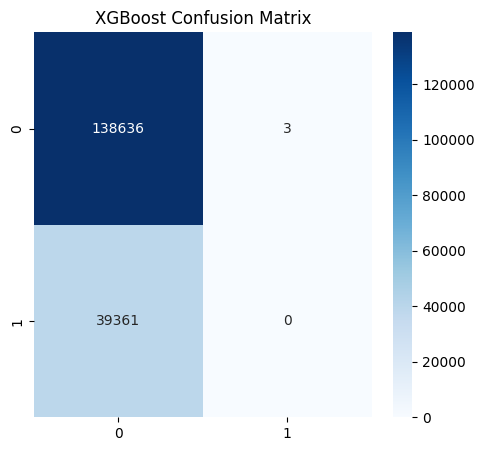

In [29]:
# step-8 Compare Performance (Confusion Matrix & ROC Curve)
# Confusion Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')

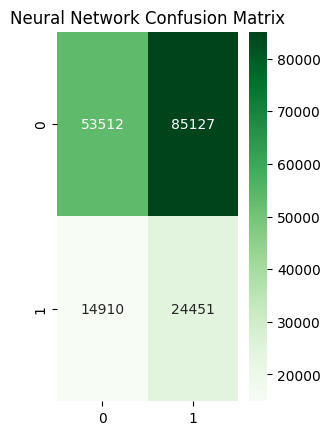

In [30]:
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_nn), annot=True, fmt='d', cmap='Greens')
plt.title('Neural Network Confusion Matrix')
plt.show()

5563/5563 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step


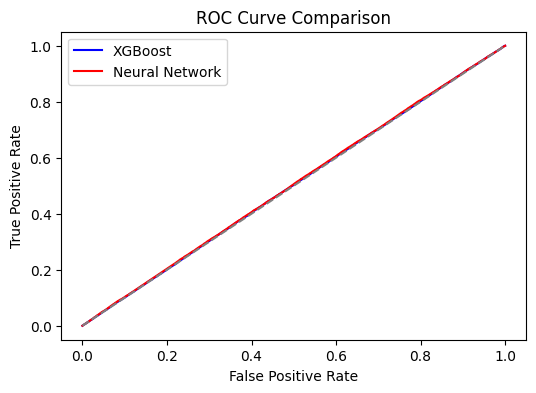

In [31]:
# ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
fpr_nn, tpr_nn, _ = roc_curve(y_test, nn_model.predict(X_test).flatten())

plt.figure(figsize=(6, 4))
plt.plot(fpr_xgb, tpr_xgb, color='blue', label='XGBoost')
plt.plot(fpr_nn, tpr_nn, color='red', label='Neural Network')
plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [32]:
# step-9 Conclusion
print("XGBoost Accuracy:", accuracy_xgb)
print("Neural Network Accuracy:", accuracy_nn)
if accuracy_nn > accuracy_xgb:
    print("Deep Learning performs better!")
else:
    print("XGBoost performs better!")

XGBoost Accuracy: 0.7788539325842697
Neural Network Accuracy: 0.43799438202247193
XGBoost performs better!
